In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib import patches
from matplotlib.pyplot import figure

import sys
sys.path.append('..')

# local library of functions to connect to image server
import calcimetry.use_server as server
from calcimetry.mongo_api import MongoInfo, MongoAPI


# Open Image and get calcimetry for image

In [6]:
img_path = server.init()  # initiate the global (privatevariables for the database

server : http://imgserver.10.68.0.250.nip.io/data/andra


In [7]:
mongo_info = MongoInfo()

In [10]:
drillname = 'KEY1205'
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    partialdrillname = f'.*{drillname}.*'
    doc = mongo_api.db['images'].find({'DrillName': {'$regex' : partialdrillname}})
    df = pd.DataFrame(list(doc))
df

,_id,ImageId,FileName,DrillName,Cote0,Cote1,PxSize,PySize,px0,px1,k_Up,k_Down,k_Arrow
0,6324254c3f00570ad37e0200,858,GTR2005-07_0037_KEY1205_0000_0093.jpg,KEY1205,0,93,1932,456,23,1927,"[[18, 127], [134, 134], [174, 142], [460, 140]...","[[15, 233], [140, 238], [446, 238], [529, 252]...","[[23, 187], [433, 191], [470, 200], [695, 206]..."
1,6324254c3f00570ad37e0201,859,GTR2005-07_0037_KEY1205_0053_0152.jpg,KEY1205,53,152,2048,450,0,2025,"[[4, 129], [644, 141], [907, 142], [1588, 140]...","[[9, 228], [485, 241], [943, 247], [1321, 248]...","[[5, 184], [285, 194], [642, 201], [1165, 205]..."
2,6324254c3f00570ad37e0202,860,GTR2005-07_0037_KEY1205_0105_0204.jpg,KEY1205,105,204,2048,456,13,2040,"[[4, 129], [535, 141], [870, 143], [1389, 142]...","[[7, 232], [538, 245], [851, 244], [1197, 246]...","[[10, 189], [194, 195], [696, 203], [1245, 206..."
3,6324254c3f00570ad37e0203,861,GTR2005-07_0037_KEY1205_0154_0254.jpg,KEY1205,154,254,2048,465,3,2043,"[[2, 134], [336, 140], [741, 147], [1417, 156]...","[[5, 232], [396, 241], [925, 254], [1169, 259]...","[[4, 189], [417, 201], [811, 209], [1384, 214]..."
4,6324254c3f00570ad37e0204,862,GTR2005-07_0037_KEY1205_0218_0310.jpg,KEY1205,219,310,2048,450,13,1883,"[[2, 126], [354, 131], [755, 139], [1293, 143]...","[[9, 222], [390, 235], [650, 243], [1037, 247]...","[[4, 179], [347, 190], [657, 197], [1291, 206]..."


In [15]:
ImageID = 859
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['measurements'].find({'ImageId': ImageID})
    df = pd.DataFrame(list(doc))
df

,_id,MeasureId,ImageId,CalciCote,CalciVals1m,CalciVals15m
0,6324254d3f00570ad37e0207,1585,859,53,19,20
1,6324254d3f00570ad37e0208,1586,859,100,22,23
2,6324254d3f00570ad37e0209,1587,859,147,17,18


Status Code 200


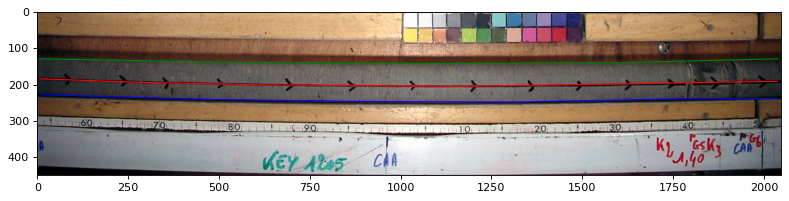

In [9]:
ImageId = 859

def draw_line(polyline, color='red'):
    x = []
    y = []
    for t in polyline:
        x.append(t[0])
        y.append(t[1])
    apath = Path(list(zip(x, y)))
    apatch = patches.PathPatch(apath, linewidth=1, facecolor='none', edgecolor=color)
    return apatch

with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['images'].find_one({'ImageId': ImageId})

    if len(doc['k_Up']) > 1:
        top_line = draw_line(doc['k_Up'], color='green')
    if doc['k_Arrow'] is not None:
        arrow_line = draw_line(doc['k_Arrow'], color='red')
    if len(doc['k_Down']) > 1:
        bottom_line = draw_line(doc['k_Down'], color='blue')

    filename = f"/data/andra/calci_photos/{drillname}/Photos/{doc['FileName']}"
    img = server.get_file(filename)

    figure(figsize=(12, 8), dpi=80)
    plt.imshow(img)
    if len(doc['k_Up']) > 1:
        plt.gca().add_patch(top_line)
    if doc['k_Arrow'] is not None:
        plt.gca().add_patch(arrow_line)
    if len(doc['k_Down']) > 1:
        plt.gca().add_patch(bottom_line)

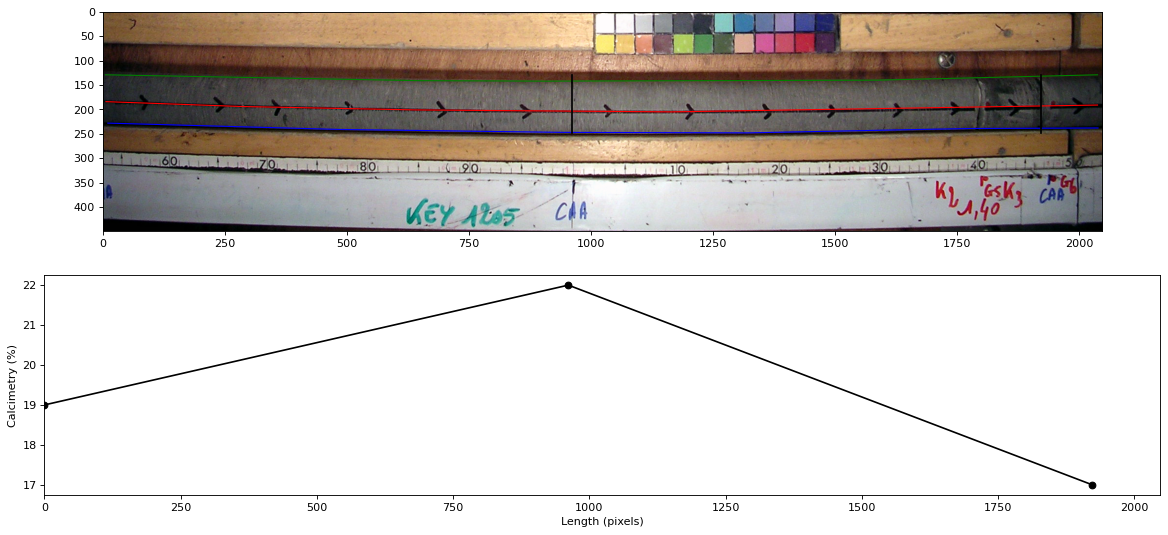

In [16]:
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['images'].find_one({'ImageId': ImageId})

    if len(doc['k_Up']) > 1:
        top_line = draw_line(doc['k_Up'], color='green')
    if doc['k_Arrow'] is not None:
        arrow_line = draw_line(doc['k_Arrow'], color='red')
    if len(doc['k_Down']) > 1:
        bottom_line = draw_line(doc['k_Down'], color='blue')

    filename = f"/data/andra/calci_photos/{drillname}/Photos/{doc['FileName']}"
    img = server.get_file(filename, quiet=True)

    figure(figsize=(18, 8), dpi=80)
    plt.subplot(211)
    plt.imshow(img)
    if len(doc['k_Up']) > 1:
        plt.gca().add_patch(top_line)
    if doc['k_Arrow'] is not None:
        plt.gca().add_patch(arrow_line)
    if len(doc['k_Down']) > 1:
        plt.gca().add_patch(bottom_line)
        
    dpxdx = (doc['px1'] - doc['px0']) / (doc['Cote1'] - doc['Cote0'])
        
    for indx, row in df.iterrows():
        if row['ImageId'] == ImageId:
            x = dpxdx * (row['CalciCote'] - doc['Cote0']) + doc['px0']
            y1 = np.array(doc['k_Down']).T[1].max()
            y2 = np.array(doc['k_Up']).T[1].min()
            plt.plot([x, x], [y1, y2], color='black')
    
    plt.subplot(212)
    
    x = []
    y = []
    for indx, row in df.iterrows():
        if row['ImageId'] == ImageId:
            x.append(dpxdx * (row['CalciCote'] - doc['Cote0']) + doc['px0'])
            y.append(row['CalciVals1m'])
    plt.plot(x, y, marker='o', color='black')
    plt.xlim(0, np.shape(img)[1])
    plt.ylabel('Calcimetry (%)')
    plt.xlabel('Length (pixels)')
            